In [7]:
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 6.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 8.2 MB/s eta 0:00:0000:0100:01


In [ ]:
!pip install Levenshtein

# Importing libraries 

In [49]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random
import time 
from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc
import Levenshtein as lev
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras


print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mediapipe.__version__)

TensorFlow v2.13.0
Mediapipe v0.10.2


In [50]:
dataset_df = pd.read_csv('/opt/homebrew/anaconda3/NLP/Project/metadata/train.csv')
tf_records = dataset_df.file_id.map(lambda x: f'/opt/homebrew/anaconda3/NLP/Project/Data/{x}.tfrecord').unique()

In [55]:
seed = 100 

# Load model script 
LPOSE = [13, 15, 17, 19, 21]  # List of indices for left hand pose
RPOSE = [14, 16, 18, 20, 22]  # List of indices for right hand pose
FRAME_LEN = 128  # Length of frames
POSE = LPOSE + RPOSE  # Combined list of pose indices
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

FEATURE_COLUMNS = X + Y + Z  # Combined list of feature columns

X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "x_" in col]  # Indices for x values in feature columns
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "y_" in col]  # Indices for y values in feature columns
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "z_" in col]  # Indices for z values in feature columns
RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "right" in col]  # Indices for right hand features
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "left" in col]   # Indices for left hand features
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "pose" in col and int(col[-2:]) in RPOSE]  # Indices for right pose features
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "pose" in col and int(col[-2:]) in LPOSE]  # Indices for left pose features

def resize_pad(x):
    '''Resize or pad the input tensor based on FRAME_LEN.'''
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))  # Pad to desired frame length
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))  # Resize to desired frame length
    return x

def extract_xyz(hand_or_pose, idx):
    '''Extract and concatenate x, y, z values.'''
    x_val = hand_or_pose[:, 0*(len(idx)//3) : 1*(len(idx)//3)]  # Extract x values
    y_val = hand_or_pose[:, 1*(len(idx)//3) : 2*(len(idx)//3)]  # Extract y values
    z_val = hand_or_pose[:, 2*(len(idx)//3) : 3*(len(idx)//3)]  # Extract z values
    return tf.concat([x_val[..., tf.newaxis], y_val[..., tf.newaxis], z_val[..., tf.newaxis]], axis=-1)  # Concatenate x, y, z values

def pre_process(x):
    '''Process landmark data.'''
    rhand = tf.gather(x, RHAND_IDX, axis=1)  # Gather right hand features
    lhand = tf.gather(x, LHAND_IDX, axis=1)  # Gather left hand features
    rpose = tf.gather(x, RPOSE_IDX, axis=1)  # Gather right pose features
    lpose = tf.gather(x, LPOSE_IDX, axis=1)  # Gather left pose features

    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)  # Find indices with NaN in right hand features
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)  # Find indices with NaN in left hand features
    rnans = tf.math.count_nonzero(rnan_idx)  # Count NaNs in right hand features
    lnans = tf.math.count_nonzero(lnan_idx)  # Count NaNs in left hand features

    if rnans > lnans:
        hand, pose, idx_hand, idx_pose = lhand, lpose, LHAND_IDX, LPOSE_IDX  # Use left hand features if more NaNs
    else:
        hand, pose, idx_hand, idx_pose = rhand, rpose, RHAND_IDX, RPOSE_IDX  # Use right hand features if more NaNs

    hand = extract_xyz(hand, idx_hand)  # Extract x, y, z values for hand features
    pose = extract_xyz(pose, idx_pose)  # Extract x, y, z values for pose features

    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]  # Calculate mean along axis 1
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]  # Calculate standard deviation along axis 1
    hand = (hand - mean) / std  # Normalize hand features

    x = tf.concat([hand, pose], axis=1)  # Concatenate normalized hand and pose features
    x = resize_pad(x)  # Resize or pad to desired frame length
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)  # Replace NaNs with zeros
    x = tf.reshape(x, (FRAME_LEN, len(idx_hand) + len(idx_pose)))  # Reshape to final format
    return x

def decode_fn(record_bytes):
    '''Decode bytes from tfrecord.'''
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}  # Define schema for parsing
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)  # Add phrase feature
    features = tf.io.parse_single_example(record_bytes, schema)  # Parse the example using the schema
    phrase = features["phrase"]  # Extract phrase feature
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])  # Convert sparse tensors to dense tensors
    landmarks = tf.transpose(landmarks)  # Transpose landmarks tensor
    return landmarks, phrase  # Return landmarks and phrase

def convert_fn(landmarks, phrase):
    '''Convert landmarks and phrase for the model.'''
    phrase = start_token + phrase + end_token  # Add start and end tokens to the phrase
    phrase = tf.strings.bytes_split(phrase)  # Split phrase into bytes
    phrase = table.lookup(phrase)  # Use a lookup table to convert bytes to indices
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode='CONSTANT', constant_values=pad_token_idx)  # Pad the phrase to a fixed length
    return pre_process(landmarks), phrase  # Pre-process landmarks and return pre-processed data along with the phrase


In [56]:
# Open the specified JSON file for reading
with open("/opt/homebrew/anaconda3/NLP/Project/metadata/character_to_prediction_index.json", "r") as f:
    # Load the JSON data into the char_to_num dictionary
    char_to_num = json.load(f)

# Define the pad_token, start_token, and end_token
pad_token = 'P'
start_token = '<'
end_token = '>'

# Define indices for the pad_token, start_token, and end_token
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

# Add the pad_token, start_token, and end_token along with their indices to the char_to_num dictionary
char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx

# Create a dictionary to map indices back to characters (reverse of char_to_num)
num_to_char = {j: i for i, j in char_to_num.items()} 

# Commenting: Load character-to-index mapping from JSON, add special tokens with indices, and create reverse mapping.


In [57]:
# Create a static hash table using TensorFlow's lookup module
table = tf.lookup.StaticHashTable(
    # Initialize the hash table with key-value pairs
    initializer=tf.lookup.KeyValueTensorInitializer(
        # Provide keys from char_to_num dictionary
        keys=list(char_to_num.keys()),
        # Provide values from char_to_num dictionary
        values=list(char_to_num.values()),
    ),
    # Set a default value for keys not found in the hash table
    default_value=tf.constant(-1),
    # Provide a name for the hash table
    name="class_weight"
)
# The hash table 'table' is now ready for use.


In [80]:
batch_size = 64  # Batch size for training and evaluation
train_len = int(0.8 * len(tf_records))  # Length of training dataset
valid_len = int(0.1 * len(tf_records))  # Length of validation dataset

# Train dataset
train_ds = tf.data.TFRecordDataset(tf_records[:train_len])  # Create a TFRecordDataset for training samples
train_ds = train_ds.map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()  # Decode, convert, batch, prefetch, and cache training data

# Validation dataset
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:train_len+valid_len])  # Create a TFRecordDataset for validation samples
valid_ds = valid_ds.map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()  # Decode, convert, batch, prefetch, and cache validation data

# Test dataset
test_ds = tf.data.TFRecordDataset(tf_records[train_len+valid_len:])  # Create a TFRecordDataset for test samples
test_ds = test_ds.map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()  # Decode, convert, batch, prefetch, and cache test data


In [95]:
class TokenEmbedding(layers.Layer):
    '''TokenEmbedding layer enriches the input sequence with both token embeddings and positional embeddings.'''
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)  # Define positional embeddings.

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)  # Token embeddings.
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)  # Positional embeddings.
        return x + positions  # Combine token and positional embeddings.

class LandmarkEmbedding(layers.Layer):
    '''LandmarkEmbedding layer processes the input through 3 1D convolutional layers,
    downsampling the sequence length with each layer
    and applying an embedding layer to map the sequence indices to dense vectors.
    The purpose of this layer is to learn hierarchical representations of the input sequence
    that can be further used in subsequent layers or models.'''
    
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)  # Define positional embeddings.

    def call(self, x):
        x = self.conv1(x)  # Apply 1D convolution.
        x = self.conv2(x)  # Apply another 1D convolution.
        return self.conv3(x)  # Apply the final 1D convolution.

class TransformerEncoder(layers.Layer):
    '''TransformerEncoder layer performs self-attention, applies residual connections,
    and introduces non-linearity through a feed-forward network.
    It has a MultiHeadAttention layer , A sequential layer and 2 Dense layers '''
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):  # Forward pass through the transformer encoder block.
        attn_output = self.att(self.layernorm1(inputs), self.layernorm1(inputs))
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output
        ffn_output = self.ffn(self.layernorm2(out1))
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        """
        Initialize the Transformer Decoder layer.

        Args:
            embed_dim: The dimension of the token embeddings.
            num_heads: The number of attention heads in multi-head attention.
            feed_forward_dim: The dimension of the feed-forward neural network.
            dropout_rate: The dropout rate for regularization.
        """
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """
        Masks the upper half of the dot product matrix in self-attention.

        This prevents the flow of information from future tokens to the current token.
        The function creates a mask with 1's in the lower triangle, counting from the lower right corner.

        Args:
            batch_size: The batch size of the input.
            n_dest: The number of destination tokens (target sequence length).
            n_src: The number of source tokens (encoder output sequence length).
            dtype: Data type of the mask.

        Returns:
            A tensor representing the causal attention mask.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        '''Forward pass through the transformer decoder block.
        Args:
            enc_out: The output of the encoder, representing the context information.
            target: The target sequence (usually the decoder input).
            training: A boolean flag indicating whether the model is in training mode.
        Returns:
            The output of the transformer decoder block.'''
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)  # Create causal attention mask.
        target_att = self.self_att(self.layernorm1(target), self.layernorm1(target), attention_mask=causal_mask)  # Self-attention with causal mask.
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training=training))
        enc_out = self.enc_att(self.layernorm2(target_norm), enc_out)  # Encoder-Decoder attention.
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training=training) + target_norm)
        ffn_out = self.ffn(self.layernorm3(enc_out_norm))  # Feed-forward network.
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training=training))
            
        return ffn_out_norm


In [96]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")  # Metric to track Levenshtein distance
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        # Initialize embeddings and layers
        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        # Create encoder layers
        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        # Create decoder layers
        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        # Decode using decoder layers
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch[0]
        target = batch[1]

        # Calculate loss and gradients for training
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Calculate Levenshtein distance for evaluation
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        # Calculate Levenshtein distance for evaluation
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training=False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training=False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

# Learning Rate Scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    # Custom learning rate schedule for training the transformer model
    def __init__(self, d_model, warmup_steps=5):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),
            "warmup_steps": self.warmup_steps.numpy()
        }

# Label Smoothing
class LabelSmoothing(tf.keras.losses.Loss):
    # Custom loss function for label smoothing
    def __init__(self, epsilon=0.1):
        super().__init__()
        self.epsilon = epsilon

    def call(self, y_true, y_pred):
        num_classes = y_pred.shape[-1]
        return -tf.reduce_sum(
            y_true * tf.math.log(y_pred + 1e-6)
            + (1 - y_true) * tf.math.log((1 - y_pred) + 1e-6)
            + y_true * self.epsilon / num_classes
        )


In [102]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=60, target_end_token_idx=61
    ):
        """Displays a batch of outputs after every 4 epochs and stores them in a DataFrame

        Args:
            batch: A test batch
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token
        self.predictions_data = []  # List to store prediction and target data
    
    def Damerau_Levenshtein(self, s1, s2):
        # Create a table to store the results of subproblems
        dp = [[0 for j in range(len(s2)+1)] for i in range(len(s1)+1)]
        # Initialize the table
        for i in range(len(s1)+1):
            dp[i][0] = i
        for j in range(len(s2)+1):
            dp[0][j] = j
        # Populate the table using dynamic programming
        for i in range(1, len(s1)+1):
            for j in range(1, len(s2)+1):
                if s1[i-1] == s2[j-1]:
                    dp[i][j] = dp[i-1][j-1]
                else:
                    dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
        # Return the edit distance
        return dp[len(s1)][len(s2)]


    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 != 0:
            return
        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break

            # Calculate the Levenshtein distance
            #lev_dist = lev.distance(target_text.replace('-', ''), prediction)

            # Append the prediction, target and levenshtein distance to the list
            self.predictions_data.append({
                "target": target_text.replace('-', ''), 
                "prediction": prediction.replace('-', ''),
                "damerau_levenshtein_distance": self.Damerau_Levenshtein(target_text.replace('-', ''), prediction)})

            print(f"target:     {target_text.replace('-', '')}")
            print(f"prediction: {prediction.replace('-', '')}\n")
            print(f"damerau_levenshtein_distance: {self.Damerau_Levenshtein(target_text.replace('-', ''), prediction)}\n")

    def get_predictions_data(self):
        # Convert the list to a DataFrame
        return pd.DataFrame(self.predictions_data)

In [104]:
num_hid = 200  # Number of hidden units

# Record the starting time
st = time.time()

# Get a batch of data from the validation dataset
batch = next(iter(valid_ds))

# Create a list to map predicted indices back to characters
idx_to_char = list(char_to_num.keys())

# Create a display callback to show outputs during training
display_cb = DisplayOutputs(batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>'])  

# Create a Transformer model
model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen=FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62
)

# Define the categorical cross-entropy loss function with label smoothing
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1,)

# Create an Adam optimizer with a custom learning rate schedule
optimizer = tf.keras.optimizers.Adam(CustomSchedule(num_hid), beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Create an accuracy metric
m1 = tf.keras.metrics.Accuracy()

# Compile the model with the defined optimizer, loss function, and metric
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[m1], jit_compile=True)

# Fit the model on the training dataset, validating on the validation dataset, and using the display callback
history = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb], epochs=20)

# Record the ending time
et = time.time()

# Print training completion message and execution time
print('-' * 50, 'Training Complete', '-' * 50)
print(f'Execution Time: {(et - st) / 60} min')


Epoch 1/20
    632/Unknown - 693s 1s/step - loss: 0.9208 - edit_dist: 1.0685target:     <2796 west golden willow drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <785 st mortherd cerive>

damerau_levenshtein_distance: 52

target:     <9734719887>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <+931141199999>

damerau_levenshtein_distance: 59

target:     <4977236992>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <9951616626>

damerau_levenshtein_distance: 59

target:     <reallyloud.co.uk/simaii>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <delen coman>

damerau_levenshtein_distance: 56

target:     <kkaicd1.pixnet.net>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <https://ww.comalalane>

damerau_levenshtein_distance: 61

target:     <8260 john r bowdoin>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <886 man mande che>

damerau_levenshtein_distance: 57

target:     <56 paper birch drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

In [105]:
# Storing the predictions to train the correction model
predictions_df = display_cb.get_predictions_data()
# predictions_df


,target,prediction,damerau_levenshtein_distance
0,<2796 west golden willow drive>PPPPPPPPPPPPPPP...,<785 st mortherd cerive>,52
1,<9734719887>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,<+931141199999>,59
2,<4977236992>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,<9951616626>,59
3,<reallyloud.co.uk/simaii>PPPPPPPPPPPPPPPPPPPPP...,<delen coman>,56
4,<kkaicd1.pixnet.net>PPPPPPPPPPPPPPPPPPPPPPPPPP...,<https://ww.comalalane>,61
...,...,...,...
635,<963 crested owl>PPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,<9963 brestedowly>,51
636,<2886 will teasley>PPPPPPPPPPPPPPPPPPPPPPPPPPP...,<2886 wiltea leney>,50
637,<josie savage>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,<8 jose salvenue gir>,57
638,<4127407457>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,<4931617744>,59


In [133]:
target = []  # Initialize an empty list to store modified target values

# Loop through each row in the predictions_df DataFrame
for i in range(predictions_df.shape[0]):
    target.append(predictions_df['target'][i].replace('P', ''))  # Remove 'P' from the target value and add it to the list


In [139]:
def damerau_levenshtein_distance(s1, s2):
    """
    Calculate the Damerau–Levenshtein distance between two strings.
    """
    len_s1 = len(s1)  # Length of the first string
    len_s2 = len(s2)  # Length of the second string
    d = [[0] * (len_s2 + 1) for _ in range(len_s1 + 1)]  # Initialize a matrix to store distances

    # Initialize the first row with values 0 to len_s2 (insertions)
    for i in range(len_s1 + 1):
        d[i][0] = i

    # Initialize the first column with values 0 to len_s1 (deletions)
    for j in range(len_s2 + 1):
        d[0][j] = j

    # Fill in the matrix using dynamic programming
    for i in range(1, len_s1 + 1):
        for j in range(1, len_s2 + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1  # Calculate substitution cost
            d[i][j] = min(
                d[i - 1][j] + 1,        # Deletion
                d[i][j - 1] + 1,        # Insertion
                d[i - 1][j - 1] + cost, # Substitution
            )
            # Check for transposition (swap adjacent characters) and update distance if needed
            if i > 1 and j > 1 and s1[i - 1] == s2[j - 2] and s1[i - 2] == s2[j - 1]:
                d[i][j] = min(d[i][j], d[i - 2][j - 2] + cost)

    return d[len_s1][len_s2]  # Return the final distance


In [144]:
# Assign the 'target' column to the 'target' variable
target = predictions_df['target']

# Create a new column 'corrected_damerau_levenshtein_distance' to store the Damerau-Levenshtein distances
predictions_df['corrected_damerau_levenshtein_distance'] = []

# Loop through each row in the DataFrame
for i in range(predictions_df.shape[0]):
    # Calculate the Damerau-Levenshtein distance between 'target' and 'prediction' strings in the current row
    dem_score = damerau_levenshtein_distance(predictions_df['target'][i], predictions_df['prediction'][i])
    
    # Append the calculated Damerau-Levenshtein distance to the 'score' list
    predictions_df['corrected_damerau_levenshtein_distance'].append(dem_score)

# Now the 'corrected_damerau_levenshtein_distance' column in the DataFrame has been populated with the calculated distances
predictions_df


,target,prediction,damerau_levenshtein_distance,corrected_damerau_levenshtein_distance
0,<2796 west golden willow drive>,<785 st mortherd cerive>,52,19
1,<9734719887>,<+931141199999>,59,9
2,<4977236992>,<9951616626>,59,8
3,<reallyloud.co.uk/simaii>,<delen coman>,56,17
4,<kkaicd1.pixnet.net>,<https://ww.comalalane>,61,19
...,...,...,...,...
635,<963 crested owl>,<9963 brestedowly>,51,4
636,<2886 will teasley>,<2886 wiltea leney>,50,5
637,<josie savage>,<8 jose salvenue gir>,57,11
638,<4127407457>,<4931617744>,59,8


In [149]:
# Calculate the mean of the corrected Damerau-Levenshtein distance column (line-to-line)
mean_distance = predictions_df['corrected_damerau_levenshtein_distance'].mean()


8.234375

In [106]:
# Saving the data to a compressed ZIP file with specific compression options
compression_opts = dict(method='zip', archive_name='predictions_20epochs.csv')
# Using the to_csv() function to write the DataFrame to a CSV file inside a ZIP archive
# The index column is excluded from the CSV file using index=False
# The compression parameter is set to apply the specified compression options
predictions_df.to_csv('predictions_20epochs.csv.zip', index=False, compression=compression_opts)


# Plotting the Training VS Validation Loss 

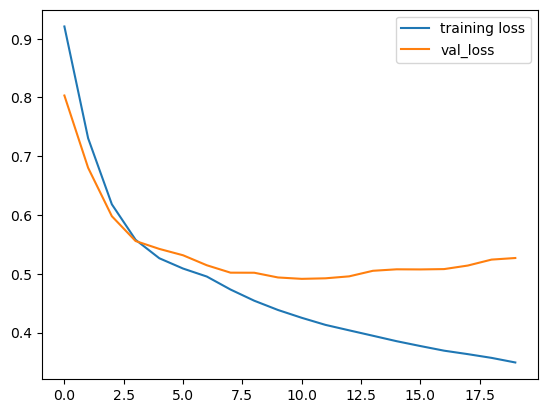

In [107]:
# Plot training loss and validation loss
plt.plot(history.history['loss'])  # Line for training loss
plt.plot(history.history['val_loss'])  # Line for validation loss
plt.legend(['training loss', 'val_loss'])  # Adding legend


# Saving the model 

In [108]:
model.save_weights("model_20epoch.h5")

#Testing the Model

# Instantiating the sentiment prediction model

# Importing Necessary Libraries

In [ ]:
import json
import tensorflow as tf
import time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Global Configuration

In [145]:
# Define the custom path for the tokenizer's word index JSON file
custom_path = '/opt/homebrew/anaconda3/NLP/Project/Final Sentiment analysis/tokenizer_word_index.json'

# Define the directory where the trained sentiment analysis model will be saved
saved_model_directory = "/opt/homebrew/anaconda3/NLP/Project/Final Sentiment analysis/Pretrained_Senti_Analysis_Model"

# Define constants for different sentiment labels
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"

# Define the maximum sequence length for tokenization
SEQUENCE_LENGTH = 300

# Taking a sample input from the DataFrame for testing
sample_input = predictions_df['prediction'][620]
# sample_input


In [146]:

# Load tokenizer.word_index from JSON file
loaded_word_index = {}
with open(custom_path, 'r') as json_file:
    loaded_word_index = json.load(json_file)
# Create and set tokenizer.word_index
tokenizer = Tokenizer(char_level=False)
tokenizer.word_index = loaded_word_index
# ... Your sentiment decoding and model loading code ...
#load the model
# Load the model using tf.keras.models.load_model
model = tf.keras.models.load_model(saved_model_directory)

In [148]:
#sentiment threshold
SENTIMENT_THRESHOLDS = (0.4, 0.7)
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

# Function to predict sentiment
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score)}  
# User input loop
#while True:
user_input = sample_input
    #if user_input.lower() == 'exit':
        #break
sentiment = predict(user_input)
print('Input to the model :',sample_input)
print("Predicted sentiment:", sentiment)

1/1 [==============================] - 0s 138ms/step
Input to the model : <129 parkelon>
Predicted sentiment: {'label': 'NEUTRAL', 'score': 0.5699917674064636}


In [152]:
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          82399200  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 82559701 (314.94 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 82399200 (314.33 MB)
_________________________________________________________________
